# The Project #
1. This is a project with minimal scaffolding. Expect to use the the discussion forums to gain insights! It’s not cheating to ask others for opinions or perspectives!
2. Be inquisitive, try out new things.
3. Use the previous modules for insights into how to complete the functions! You'll have to combine Pillow, OpenCV, and Pytesseract
4. There are hints provided in Coursera, feel free to explore the hints if needed. Each hint provide progressively more details on how to solve the issue. This project is intended to be comprehensive and difficult if you do it without the hints.

### The Assignment ###
Take a [ZIP file](https://en.wikipedia.org/wiki/Zip_(file_format)) of images and process them, using a [library built into python](https://docs.python.org/3/library/zipfile.html) that you need to learn how to use. A ZIP file takes several different files and compresses them, thus saving space, into one single file. The files in the ZIP file we provide are newspaper images (like you saw in week 3). Your task is to write python code which allows one to search through the images looking for the occurrences of keywords and faces. E.g. if you search for "pizza" it will return a contact sheet of all of the faces which were located on the newspaper page which mentions "pizza". This will test your ability to learn a new ([library](https://docs.python.org/3/library/zipfile.html)), your ability to use OpenCV to detect faces, your ability to use tesseract to do optical character recognition, and your ability to use PIL to composite images together into contact sheets.

Each page of the newspapers is saved as a single PNG image in a file called [images.zip](./readonly/images.zip). These newspapers are in english, and contain a variety of stories, advertisements and images. Note: This file is fairly large (~200 MB) and may take some time to work with, I would encourage you to use [small_img.zip](./readonly/small_img.zip) for testing.

Here's an example of the output expected. Using the [small_img.zip](./readonly/small_img.zip) file, if I search for the string "Christopher" I should see the following image:
![Christopher Search](./readonly/small_project.png)
If I were to use the [images.zip](./readonly/images.zip) file and search for "Mark" I should see the following image (note that there are times when there are no faces on a page, but a word is found!):
![Mark Search](./readonly/large_project.png)

Note: That big file can take some time to process - for me it took nearly ten minutes! Use the small one for testing.

In [1]:
import zipfile
import json
from PIL import Image , ImageDraw
import pytesseract
import numpy as np
import kraken
from kraken import pageseg
import cv2 as cv
from zipfile import ZipFile
import os
op = Image.open
two_col = "readonly/two_col.png"
# loading the face detection classifier
face_cascade = cv.CascadeClassifier('readonly/haarcascade_frontalface_default.xml')


In [6]:
# the pageseg() function I saw that there are a few parameters we can supply in order to improve 
# segmentation. One of these is the black_colseps parameter. If set to True, kraken will assume that 
# columns will be separated by black lines. This isn't our case here, but, I think we have all of the
# tools to go through and actually change the source image to have a black separator between columns.
#
# The first step is that I want to update the show_boxes() function. I'm just going to do a quick
# copy and paste from the above but add in the black_colseps=True parameter
def get_text_boxes(imglocation,datalocation , debug=False , cache = True):
    '''Modifies the passed image to show a series of bounding boxes on an image as run by kraken
    
    :param img: A PIL.Image object
    :return img: The modified PIL.Image object
    '''
    # just a short hand
    op = lambda x : Image.open(x).convert('1')
    # check if the user wants to cache the data
    if cache:
        if os.path.exists('{}/{}-metadata.txt'.format(datalocation,filename_extentionless(imglocation))):
            with open('{}/{}-metadata.txt'.format(datalocation,filename_extentionless(imglocation)),'r') as f:
                data = json.loads(f.read())
                try:
                    v = data['textBoxes']
                    if debug:
                        print('get_text_boxes; cache hit')
                    return data['textBoxes']
                except:
                    if debug:
                        print('get_text_boxes;file found no textBoxes; cache not hit')
                    img = op(imglocation)
                    bounding_boxes=pageseg.segment(img.convert('1'), black_colseps=True)['boxes']

                    data['textBoxes']=bounding_boxes
                    with open('{}/{}-metadata.txt'.format(datalocation,filename_extentionless(imglocation)),'w')as f:
                        f.write(json.dumps(data))
                    return data['textBoxes']
        else:
            if debug:
                print('get_text_boxes;file not found; cache not hit')
            img = op(imglocation)
            bounding_boxes=pageseg.segment(img.convert('1'), black_colseps=True)['boxes']
            data = dict()
            data['textBoxes']=bounding_boxes
            with open('{}/{}-metadata.txt'.format(datalocation,filename_extentionless(imglocation)),'w')as f:
                f.write(json.dumps(data))
            return data['textBoxes']
    else:
        if os.path.exists('{}/{}-metadata.txt'.format(datalocation,filename_extentionless(imglocation))):
            with open('{}/{}-metadata.txt'.format(datalocation,filename_extentionless(imglocation)),'r') as f:
                data = json.loads(f.read())
                if debug:
                    print('get_text_boxes;file found no textBoxes; cache not hit')
                img = op(imglocation)
                bounding_boxes=pageseg.segment(img.convert('1'), black_colseps=True)['boxes']

                data['textBoxes']=bounding_boxes
                with open('{}/{}-metadata.txt'.format(datalocation,filename_extentionless(imglocation)),'w')as f:
                    f.write(json.dumps(data))
                return data['textBoxes']
        else:
            if debug:
                print('get_text_boxes;file not found; cache not hit')
            img = op(imglocation)
            bounding_boxes=pageseg.segment(img.convert('1'), black_colseps=True)['boxes']
            data = dict()
            data['textBoxes']=bounding_boxes
            with open('{}/{}-metadata.txt'.format(datalocation,filename_extentionless(imglocation)),'w')as f:
                f.write(json.dumps(data))
            return data['textBoxes']
    # Lets bring in our ImageDraw object
    
    # And grab a drawing object to annotate that image
    # drawing_object=ImageDraw.Draw(img)--for showing
    # We can create a set of boxes using pageseg.segment

    # Now lets go through the list of bounding boxes
    # for box in bounding_boxes:--for showing
        # An just draw a nice rectangle
        # drawing_object.rectangle(box, fill = None, outline ='red')--for showing
    # And to make it easy, lets return the image object
    # return img , bounding_boxes --for showing
#     return  bounding_boxes

In [7]:
def pil_faces_list(imglocation,boxes):
    
    # Lets bring in our ImageDraw object
    imgs =[]
    img = op(imglocation)
    # And grab a drawing object to annotate that image
    drawing_object=ImageDraw.Draw(img)
    # We can create a set of boxes using pageseg.segment

    # Now lets go through the list of bounding boxes
    for box in boxes:
        # An just draw a nice rectangle
        tx,ty,w,h = box
        face = (tx,ty,tx+w ,ty+h)
        imgs.append(img.crop(face))
    # And to make it easy, lets return the image object
    return imgs 

In [8]:
# Ok, so the average height of a line is 31.
# Now, we want to scan through the image - looking at each pixel in turn - to determine if there
# is a block of whitespace. How bit of a block should we look for? That's a bit more of an art
# than a science. Looking at our sample image, I'm going to say an appropriate block should be
# one char_width wide, and six line_heights tall. But, I honestly just made this up by eyeballing
# the image, so I would encourage you to play with values as you explore.
# Lets create a new box called gap box that represents this area
gap_box=(0,0,50,200)
gap_box

(0, 0, 50, 200)

In [9]:
def gap_check(img, location):
    '''Checks the img in a given (x,y) location to see if it fits the description
    of a gap_box
    :param img: A PIL.Image file
    :param location: A tuple (x,y) which is a pixel location in that image
    :return: True if that fits the definition of a gap_box, otherwise False
    '''
    xmax = location[0]+gap_box[2]
    ymax = location[1]+gap_box[3]
    if ( xmax>= img.shape[1]-2) or (ymax >= img.shape[0]-2):
        return False
    if ( img [location[1] , location[0]] !=255 ):
        return False
    if (    (img[location[1]:ymax , location[0]:xmax] != 255).sum() != 0 ):
        return False
    # If we have managed to walk all through the gap_box without finding any non-white pixels
    # then we can return true -- this is a gap!
    return True

In [10]:
def draw_sep(img_cv,location):
    '''Draws a line in img in the middle of the gap discovered at location. Note that
    this doesn't draw the line in location, but draws it at the middle of a gap_box
    starting at location.
    :param img: A PIL.Image file
    :param location: A tuple(x,y) which is a pixel location in the image
    '''
    # First lets bring in all of our drawing code
    # next, lets decide what the middle means in terms of coordinates in the image
    x1=location[0]+int(gap_box[2]/2)
    # and our x2 is just the same thing, since this is a one pixel vertical line
    x2= min(x1,img_cv.shape[1]-1)
    # our starting y coordinate is just the y coordinate which was passed in, the top of the box
    y1=location[1]
    # but we want our final y coordinate to be the bottom of the box
    # min(y1+gap_box[3] 
    y2= img_cv.shape[0]-1
    step = int((y2 - y1)/2)
    for i in range(10):
        if (img_cv[y1:y2 , x2]!=255).sum() ==0 :
            y2 += step
            step = int(step/2)
        else:
            y2 -= step
            step = int(step/2)
        if (y2 > img_cv.shape[0]-1):
            y2 = img_cv.shape[0]-1
            break
    img_cv[ y1:y2 , x2 ] = 0
    return img_cv

In [11]:
# # Lets read in our test image and convert it through binarization
# i=Image.open(two_col).convert("L")
# im = cv.imread(two_col)
# # And we'll convert it to grayscale using the cvtColor image
# im = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
# print (im[0])
# master_dp_boxes = []
# print (gap_check(im,(0,0) , master_dp_boxes))
# # display(Image.fromarray(im,"L"))
# # cv.imshow('skel',im)
# image1 = Image.fromarray(im[:200 , :200], "L")
# image = Image.fromarray(im, "L")
# display(image1)

In [12]:
def process_image(imgstr ,destroot, debug = False):
    '''Takes in an image of text and adds black vertical bars to break up columns
    :param img: A PIL.Image file
    :return: A modified PIL.Image file
    '''
    if os.path.exists('{}/{}'.format(destroot,filename_withextention(imgstr))):
        if debug:
            print('process_image a.k.a columed; cache hit')
        im = cv.imread('{}/{}'.format(destroot,filename_withextention(imgstr)))
        return im
    else:
        if debug:
            print('process_image a.k.a columed; cache not hit')
        im_cv = cv.cvtColor(cv.imread(imgstr), cv.COLOR_BGR2GRAY)
        # we'll start with a familiar iteration process
        for x in range(im_cv.shape[1]):
            for y in range(im_cv.shape[0]):
                # check if there is a gap at this point
                    if (gap_check(im_cv, (x,y))):
                        # then update image to one which has a separator drawn on it
                        draw_sep(im_cv, (x,y))
        # and for good measure we'll return the image we modified
        cv.imwrite('{}/{}'.format(destroot,filename_withextention(imgstr)), im_cv)
        return im_cv


In [16]:
def read_page_boxes (imglocation , boxes ,metaprefix , debug = False , cache = True):
    op = lambda x : Image.open(x).convert("1")
    if cache:
        if os.path.exists('{}-metadata.txt'.format(metaprefix)):
            data = dict()
            with open('{}-metadata.txt'.format(metaprefix),'r') as f:
                data = json.loads(f.read())
            try:
                v = data['text']
                if debug:
                    print('read_page_boxes; cache hit')
                return v
            except:
                if debug:
                    print('read_page_boxes;file found no textBoxes; cache not hit')
                all_txt = ''
                im = op(imglocation)
                # im = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
                for box in boxes:
                    x1,y1,x2,y2 = box
                    b = (x1 -5, y1 -5 ,x2 +5 , y2 +5)
                    # temp_cv_img = im[ y1:y2 , x1:x2 ]
                    temp_img = im.crop(b)
                    # display(temp_img)
                    text = pytesseract.image_to_string(temp_img)
                    text = text.replace('|' , "")
                    text = text.replace('\n' , ' ')
                    # print(text)
                    all_txt = all_txt + text
                data['text']=all_txt.lower()
                with open('{}-metadata.txt'.format(metaprefix),'w')as f:
                    f.write(json.dumps(data))
                return data['text']
        else:
            data = dict()
            if debug:
                print('read_page_boxes;file not found; cache not hit')
            all_txt = ''
            im = op(imglocation)
            # im = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
            for box in boxes:
                x1,y1,x2,y2 = box
                b = (x1 -5, y1 -5 ,x2 +5 , y2 +5)
                # temp_cv_img = im[ y1:y2 , x1:x2 ]
                temp_img = im.crop(b)
                # display(temp_img)
                text = pytesseract.image_to_string(temp_img)
                text = text.replace('|' , "")
                text = text.replace('\n' , ' ')
                # print(text)
                all_txt = all_txt + text
            data['text']=all_txt.lower()
            with open('{}-metadata.txt'.format(metaprefix),'w')as f:
                f.write(json.dumps(data))
            return data['text']
    else:
        if os.path.exists('{}-metadata.txt'.format(metaprefix)):
            data = dict()
            with open('{}-metadata.txt'.format(metaprefix),'r') as f:
                data = json.loads(f.read())
            if debug:
                print('read_page_boxes;file found no textBoxes; cache not hit')
            all_txt = ''
            im = op(imglocation)
            # im = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
            for box in boxes:
                x1,y1,x2,y2 = box
                b = (x1 -5, y1 -5 ,x2 +5 , y2 +5)
                # temp_cv_img = im[ y1:y2 , x1:x2 ]
                temp_img = im.crop(b)
                # display(temp_img)
                text = pytesseract.image_to_string(temp_img)
                text = text.replace('|' , "")
                text = text.replace('\n' , ' ')
                # print(text)
                all_txt = all_txt + text
            data['text']=all_txt.lower()
            with open('{}-metadata.txt'.format(metaprefix),'w')as f:
                f.write(json.dumps(data))
            return data['text']
        else:
            data = dict()
            if debug:
                print('read_page_boxes;file not found; cache not hit')
            all_txt = ''
            im = op(imglocation)
            # im = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
            for box in boxes:
                x1,y1,x2,y2 = box
                b = (x1 -5, y1 -5 ,x2 +5 , y2 +5)
                # temp_cv_img = im[ y1:y2 , x1:x2 ]
                temp_img = im.crop(b)
                # display(temp_img)
                text = pytesseract.image_to_string(temp_img)
                text = text.replace('|' , "")
                text = text.replace('\n' , ' ')
                # print(text)
                all_txt = all_txt + text
            data['text']=all_txt.lower()
            with open('{}-metadata.txt'.format(metaprefix),'w')as f:
                f.write(json.dumps(data))
            return data['text']

In [18]:
face_cascade = cv.CascadeClassifier('readonly/haarcascade_frontalface_default.xml')
eye_cascade = cv.CascadeClassifier('readonly/haarcascade_eye.xml')
# Ok, with the classifiers loaded, we now want to try and detect a face. Lets pull in the
# picture we played with last time
def get_faces_list (imgstr, debug = False ,cache = True ):
    #works since imgstr is techniqaly imglocation
    if cache:
        if os.path.exists('{}-metadata.txt'.format(imgstr[:-4])):
            with open('{}-metadata.txt'.format(imgstr[:-4]),'r') as f:
                data = json.loads(f.read())
                try:
                    v = data['faces']
                    if debug:
                        print('get_faces_list ; cache hit')
                    return v
                except:
                    if debug:
                        print('get_faces_list ;found file but no faces; cache not hit')
                    img = cv.imread(imgstr)
                    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
                    faces = face_cascade.detectMultiScale(gray , scaleFactor=1.5 , minNeighbors = 5)
                    try:
                        data["faces"] = faces.tolist()
                    except:
                        data["faces"]= []
                        return []
                    with open('{}-metadata.txt'.format(imgstr[:-4]), "w")as f:
                        f.write(json.dumps(data))
                    return faces
        else:
            if debug:
                print('get_faces_list ;no file; cache not hit')
            img = cv.imread(imgstr)
            gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
            faces = face_cascade.detectMultiScale(gray, scaleFactor=1.5 , minNeighbors = 5)
            data= dict()
            try:
                data["faces"] = faces.tolist()
            except:
                data["faces"]= []
                return []
            with open('{}-metadata.txt'.format(imgstr[:-4]), "w")as f:
                f.write(json.dumps(data))
        return faces
    else:
        with open('{}-metadata.txt'.format(imgstr[:-4]),'r') as f:
                data = json.loads(f.read())
        if debug:
            print('get_faces_list ;found file but no faces; cache not hit')
        img = cv.imread(imgstr)
        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray , scaleFactor=1.5 , minNeighbors = 5)
        try:
            data["faces"] = faces.tolist()
        except:
            data["faces"]= []
            return []
        with open('{}-metadata.txt'.format(imgstr[:-4]), "w")as f:
            f.write(json.dumps(data))
        return faces
    
def show_rects(faces , imgstr):
    #Lets read in our gif and convert it
    pil_img=Image.open(imgstr).convert("RGB")
    # Set our drawing context
    drawing=ImageDraw.Draw(pil_img)
    # And plot all of the rectangles in faces
    for x,y,w,h in faces:
        drawing.rectangle((x,y,x+w,y+h), outline="white")
    #Finally lets display this
    display(pil_img)
def faces_to_pics(faces , im):
    blacked = []
    for face in faces:
        box = (face[0] , face[1] , face[0]+face[2],face[1]+face[3])
        tx , ty , bx,by = box
        while (im[ ty:by , tx]!=255).sum()!=0:
            tx = tx - 5
            if tx<0:
                break
        while (im[ ty:by , bx]!=255).sum()!=0:
            bx = bx + 5
            if bx >= im.shape[1]:
                break
        while (im[ ty , tx:bx]!=255).sum()!=0:
            ty = ty - 5
            if ty<0:
                break
        while (im[ by , tx:bx]!=255).sum()!=0:
            by = by + 5
            if by >= im.shape[0]:
                break
            blacked.append((tx,ty,bx,by))
    return blacked
def blacken_cv_pic(imgstr,faces ,destroot, debug = False):
    imMaxSize = 300
    if os.path.exists('{}/{}'.format(destroot,filename_withextention(imgstr))):
        if debug:
            print('blacken_cv_pic cache hit')
        im = cv.imread('{}/{}'.format(destroot,filename_withextention(imgstr)))
        return im
    else:
        if debug:
            print('blacken_cv_pic not hit')
        im = cv.imread(imgstr)
        im = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
        pics = faces_to_pics(faces,im)
        for pic in pics:
            tx,ty,bx,by = pic
            if (bx-tx)>imMaxSize and (by-ty)>imMaxSize:
                im[ty:by,tx:bx] = 0
        cv.imwrite('{}/{}'.format(destroot,filename_withextention(imgstr)), im)
        return im 



In [19]:
def blacken_PIL_image(imgstr , bounding_boxes , debug = False):
    '''Modifies the passed image to show a series of bounding boxes on an image as run by kraken
    
    :param img: A PIL.Image object
    :return img: The modified PIL.Image object
    '''
    imMaxSize = 300
    if os.path.exists('{}/{}'.format(destroot,filename_withextention(imgstr))):
        if debug:
            print('blacken_PIL_image cache hit')
        return op('{}/{}'.format(destroot,filename_withextention(imgstr)))
    else:
        img = op(imgstr)
        drawing_object=ImageDraw.Draw(img)
        for box in bounding_boxes:
            # An just draw a nice rectangle
            tx,ty,bx,by = box
            if (bx-tx)>imMaxSize and (by-ty)>imMaxSize:
                drawing_object.rectangle(box, fill =(0,0,0) , outline ='black')
        # And to make it easy, lets return the image object
        img.save('{}/{}'.format(destroot,filename_withextention(imgstr)))
        if debug:
            print("blacken_PIL_image added to cache")
        return img

In [22]:
def filename_extentionless(s):
    for i in range(len(s)-1,0,-1):
        if (s[i]=='/'):
            return s[i+1:-4]
    return   s
def filename_withextention(s):
    for i in range(len(s)-1,0,-1):
        if (s[i]=='/'):
            return s[i+1:]
    return s

In [ ]:
def model(ziplocation , magic_word,debug=False):
    zipname = filename_extentionless(ziplocation)
    try:
        os.mkdir(zipname)
    except:
        pass
    try:
        os.mkdir('{}/imageless'.format(zipname))
        os.mkdir('{}/columed'.format(zipname))
    except:
        pass
    dicList =[]
    # {imgstr:string , faces:pil-img-list , text:string}
    with ZipFile(ziplocation , 'r') as zipObj:
        inzip_filenames = map((lambda x: "{}/{}".format(zipname,x.filename)),zipObj.infolist())
        for imglocation in inzip_filenames:
            # print('->'+imglocation)
            zipObj.extract( imglocation[len(zipname)+1:] , path=zipname, pwd=None)
            pic_dic = dict()
            pic_dic['faces']=get_faces_list(imglocation,debug)
            blacken_cv_pic(imglocation,pic_dic['faces'],"{}/imageless".format(zipname),debug)
            process_image(
                '{}/imageless/{}'.format(zipname,filename_withextention(imglocation)),
                "{}/columed".format(zipname),
                         debug)
            pic_dic['textBoxes'] = get_text_boxes ('{}/columed/{}'.format(zipname,filename_withextention(imglocation)),
                        imglocation[:-len(filename_withextention(imglocation))],
                                                   debug , False
                       )
            pic_dic['text'] = read_page_boxes(
                '{}/columed/{}'.format(zipname,filename_withextention(imglocation)),
                pic_dic['textBoxes'],
                imglocation[:-4],debug, False
                            )
#             if 'small_img/a-0.png' == imglocation:
#                 print(pic_dic['text'])
            if magic_word.lower() in pic_dic['text']:
                imgs = pil_faces_list(imglocation,pic_dic['faces'])
                if len(imgs)>0 :
                    first_image=imgs[0].resize((100,100))
                    contact_sheet= Image.new(first_image.mode, (first_image.width*5,(int(len(imgs)/5)+1) * first_image.height))
                    x=0
                    y=0
                    for img in imgs :
                        # Lets paste the current image into the contact sheet
                        contact_sheet.paste(img.resize((100,100)), (x, y) )
                        # Now we update our X position. If it is going to be the width of the image, then we set it to 0
                        # and update Y as well to point to the next "line" of the contact sheet.
                        if x+first_image.width == contact_sheet.width:
                            x=0
                            y=y+first_image.height
                        else:
                            x=x+first_image.width
                    print ("in {} we found a match:".format(filename_withextention(imglocation)))
                    display(contact_sheet)
                else:
                    print ("in {} we found a match:".format(filename_withextention(imglocation)))
                    print ("But there is no images!")
            else:
                print("No mentions of {} in {}".format(magic_word , filename_withextention(imglocation)))

get_faces_list ; cache hit
blacken_cv_pic cache hit
process_image a.k.a columed; cache hit
get_text_boxes;file found no textBoxes; cache not hit
read_page_boxes;file found no textBoxes; cache not hit
in a-0.png we found a match:


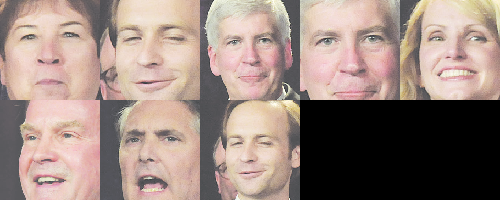

get_faces_list ; cache hit
blacken_cv_pic cache hit
process_image a.k.a columed; cache hit
get_text_boxes;file found no textBoxes; cache not hit


In [ ]:

magic_word = 'christopher'#'Mark'
a= 'small_img.zip'
b = 'images.zip'
model('readonly/'+a , magic_word,True)

In [ ]:
magic_word = 'Mark'
model('readonly/'+b , magic_word,True)